In [1]:
from qiskit.circuit.library import QFT
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from qiskit import transpile, QuantumCircuit
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling
import numpy as np
from copy import deepcopy

num_qubits = 8

circuit = cp_fraction(num_qubits, 2*num_qubits, fraction=0.5, seed=57)

# circuit = QFT(num_qubits, do_swaps=False)

num_partitions = 4 # Define the number of partitions or QPUs you will distribute over
depth = circuit.depth()

qpu_size = num_qubits // num_partitions + 1 # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list



# Create a quantum network with the specified number of qubits and partitions

# If we do not specificy the connectivity, we have all-to-all by default.

coupling = linear_coupling(num_partitions)

initial_network = QuantumNetwork(qpu_sizes, qpu_connectivity=coupling)

network = deepcopy(initial_network)

basis_gates = ['u', 'cp']

# Transpile the circuit to the basis gates
circuit = transpile(circuit, basis_gates=basis_gates)

print(f'Number of qubits in circuit {circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')

Number of qubits in circuit 8
Circuit depth: 16


In [2]:
from disqco.graphs.coarsening.network_coarsener import NetworkCoarsener
import time
import multiprocessing as mp
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph, SubGraphManager
from disqco.parti.FM.FM_methods import *

graph = QuantumCircuitHyperGraph(circuit)


net_coarsener = NetworkCoarsener(network)
initial_graph = deepcopy(graph)

start = time.time()

net_coarsener.coarsen_network_recursive(l=2)

stop = time.time()

print(f"Time to coarsen network: {stop - start:.2f} seconds")

for i in range(len(net_coarsener.network_coarse_list)-1):

    network_coarse = net_coarsener.network_coarse_list[-1]
    network_coarse.active_nodes = set([node for node in network_coarse.qpu_graph.nodes])

network_level_list = []
network_level_list.append([[network_coarse, set([key for key in network_coarse.mapping])]])
networks = network_level_list[0]

start = time.time()

for i in range(len(net_coarsener.network_coarse_list)-1):
    networks = net_coarsener.cut_network(network_level_list[i], level=i)
    network_level_list.append(networks)

stop = time.time()

print(f"Time to cut networks: {stop - start:.2f} seconds")

sub_graph_manager = SubGraphManager(initial_graph)
pool = mp.Pool(processes=mp.cpu_count())

subgraphs = [graph]

initial_node_list = [[i for i in range(initial_graph.num_qubits)] for t in range(initial_graph.depth)]
node_list = initial_node_list
%load_ext jupyter_tikz

Number of layers: 18
Time to coarsen network: 0.00 seconds
Time to cut networks: 0.00 seconds


In [3]:
from disqco.parti.FM.partition_and_build import partition_and_build_subgraphs
from disqco.drawing.tikz_drawing import draw_subgraph_tikz, draw_graph_tikz

for level, network_list in enumerate(network_level_list):

    networks = network_list
    sub_assignments = []
    subgraph_list = []
    node_maps = []
    qpu_size_list = []  
    sub_partitions_list = []
    dummy_node_list = []
    node_maps = []
    index_list = []

    node_list_list = []
    assignment_map_list = []

    for g in subgraphs:
        
        if level == 0:
            node_list = initial_node_list
        else:
            node_list = order_nodes(g)


        # for layer in node_list:
        #     print(f'Node list layer: {layer}')
        max_qubits_layer = max([len(layer) for layer in node_list])
        g.num_qubits = max_qubits_layer
        assignment_map, sorted_node_list = map_assignment(node_list)
        # for layer in sorted_node_list:
        #     print(f'Sorted node list layer: {layer}')
        #     print(f'Layer length: {len(layer)}')
        node_list_list.append(sorted_node_list)
        assignment_map_list.append(assignment_map)

    for i, network_info in enumerate(networks):
        network = network_info[0]
        net_graph = network.qpu_graph
        # nx.draw(net_graph, with_labels=True)
        # plt.show()
        active_nodes = network_info[1]
        index_list.append(i*len(active_nodes))

        qpu_sizes = {qpu : network.qpu_graph.nodes[qpu]['size'] for qpu in active_nodes}
        print(f"QPU sizes for network {i}: {qpu_sizes}")
        qpu_size_list.append(qpu_sizes)
        # node_list = order_nodes(subgraphs[i])
        node_list = node_list_list[i]
        sub_partitions = set_initial_sub_partitions(network, node_list, active_nodes,assignment_map_list[i])


        

        sub_partitions_list.append(sub_partitions)
        subnet, active_nodes = networks[i]

        subnet.qpu_sizes = qpu_size_list[i]
        k = 0
        node_map = {}
        for node in subnet.qpu_graph.nodes:
            if node in active_nodes:
                node_map[k] = node
                k += 1

        node_maps.append(node_map)
        subgraph = subgraphs[i]



        dummy_nodes = set()
        for node in subgraph.nodes:
            if node[0] == 'dummy':
                dummy_nodes.add(node)
                qpu = node[2]
                dummy_counter = node[3]
                node_map[k+dummy_counter] = qpu
        dummy_node_list.append(dummy_nodes) 
        print(f"Dummy nodes for subgraph {i}: {dummy_nodes}")

        # if level == 0:
        #     fig = draw_graph_tikz(graph, sub_partitions, qpu_sizes, assignment_map=assignment_map_list[i])
        #     display(fig)         
        # fig = draw_subgraph_tikz(subgraph, sub_partitions, qpu_sizes, assignment_map=assignment_map_list[i], node_map=node_maps[i], tikz_raw=False)
        # display(fig)


    arg_list = [(subgraphs[i],
                sub_partitions_list[i],
                qpu_size_list[i],
                len(networks[i][1]),
                None,
                None,
                10,
                True,
                None,
                False,
                False,
                None,
                networks[i][0],
                node_maps[i],
                assignment_map_list[i],
                dummy_node_list[i],
                node_list_list[i],
                level,
                network_level_list,
                sub_graph_manager,
                subgraph_list,
                sub_assignments,
                index_list[i],
                None) for i in range(len(networks))
                ]


    results = []
    node_maps = node_maps
    assignment_map_list = assignment_map_list
    start = time.time()
    for args in arg_list:
        result = partition_and_build_subgraphs(*args)
        results.append(result)
    stop = time.time()
    print(f"Time to partition and build all subgraphs for level {level}: {stop - start:.2f} seconds")

    sub_assignments = [result[0] for result in results]
    # for i in range(len(sub_assignments)):
    #     fig = draw_subgraph_tikz(subgraphs[i], sub_assignments[i][0], qpu_sizes, assignment_map=assignment_map_list[i], node_map=node_maps[i], tikz_raw=False)
    #     display(fig)
    for i in range(len(sub_assignments)):
        sub_assignment = sub_assignments[i][0]
        for j in range(len(sub_assignment)):
            print(f"Sub assignment {i}, layer {j}: {sub_assignment[j]}")
            num_0s = sum([1 for x in sub_assignment[j] if x == 0])
            print(f"Number of 0s in layer {j}: {num_0s}")
            num_1s = sum([1 for x in sub_assignment[j] if x == 1])
            print(f"Number of 1s in layer {j}: {num_1s}")
    if level == len(network_level_list)-1:
        subgraph_list = subgraphs
        sub_assignments = [result[0] for result in results]

        new_sub_assignment_list = []
        for i in range(len(sub_assignments)):
            new_sub_assignment_list += sub_assignments[i]
        sub_assignments = new_sub_assignment_list

    else:
        subgraph_list = [result[1] for result in results]
        new_subgraph_list = []
        for i in range(len(subgraph_list)):
            new_subgraph_list += subgraph_list[i]
        subgraph_list = new_subgraph_list
        
    
    subgraphs = subgraph_list


def stitch_solution(subgraphs, sub_assignments, node_maps, assignment_maps, num_qubits):
    final_assignment = [[None for _ in range(num_qubits)] for _ in range(len(sub_assignments[0]))]

    for i, sub_ass in enumerate(sub_assignments):
        ass_map = assignment_maps[i]
        subgraph = subgraphs[i]
        node_map = node_maps[i]
        for node in subgraph.nodes:
            if node[0] == 'dummy':
                continue
            q, t = node  # Assuming node is a tuple (q, t)
            sub_node = ass_map[(q,t)]
            ass = sub_ass[sub_node[1]][sub_node[0]]
            final_assignment[t][q] = node_map[ass]
    
    return final_assignment


# num_partitions = len(initial_network.qpu_graph.nodes)
# final_assignment = stitch_solution(subgraphs, sub_assignments[0:len(node_maps)], node_maps, assignment_map_list, initial_graph.num_qubits)    
# cost = calculate_full_cost_hetero(initial_graph, final_assignment, num_partitions, network=initial_network)

QPU sizes for network 0: {1: 5, 3: 5}
Free indices, node (0, 0) assigned to sub node (0, 0)
Free indices, node (1, 0) assigned to sub node (1, 0)
Free indices, node (2, 0) assigned to sub node (2, 0)
Free indices, node (3, 0) assigned to sub node (3, 0)
Free indices, node (4, 0) assigned to sub node (4, 0)
Free indices, node (5, 0) assigned to sub node (5, 0)
Free indices, node (6, 0) assigned to sub node (6, 0)
Free indices, node (7, 0) assigned to sub node (7, 0)
Free indices, node (0, 1) assigned to sub node (0, 1)
Free indices, node (1, 1) assigned to sub node (1, 1)
Free indices, node (2, 1) assigned to sub node (2, 1)
Free indices, node (3, 1) assigned to sub node (3, 1)
Free indices, node (4, 1) assigned to sub node (4, 1)
Free indices, node (5, 1) assigned to sub node (5, 1)
Free indices, node (6, 1) assigned to sub node (6, 1)
Free indices, node (7, 1) assigned to sub node (7, 1)
Free indices, node (0, 2) assigned to sub node (0, 2)
Free indices, node (1, 2) assigned to sub no

In [4]:
# Debug positioning issues
print("Debugging positioning and space mapping issues...")

# Let's examine what's happening with the first subgraph
if 'subgraphs' in locals() and len(subgraphs) > 0:
    debug_subgraph = subgraphs[0]
    print(f"First subgraph has {len(debug_subgraph.nodes)} nodes")
    
    # Count different types of nodes
    regular_nodes = []
    dummy_nodes = []
    
    for node in debug_subgraph.nodes:
        if isinstance(node, tuple) and len(node) >= 2:
            if node[0] == "dummy":
                dummy_nodes.append(node)
            else:
                regular_nodes.append(node)
    
    print(f"Regular nodes: {len(regular_nodes)}")
    print(f"Dummy nodes: {len(dummy_nodes)}")
    
    if len(regular_nodes) > 0:
        print("Sample regular nodes:", regular_nodes[:5])
    if len(dummy_nodes) > 0:
        print("Sample dummy nodes:", dummy_nodes[:5])
    
    # Check if we have assignment maps
    if 'assignment_map_list' in locals() and len(assignment_map_list) > 0:
        debug_assignment_map = assignment_map_list[0]
        print(f"Assignment map has {len(debug_assignment_map)} entries")
        print("Sample assignment map entries:", list(debug_assignment_map.items())[:5])
    
    # Check sub_partitions
    if 'sub_partitions_list' in locals() and len(sub_partitions_list) > 0:
        debug_partitions = sub_partitions_list[0]
        print(f"Sub partitions shape: {len(debug_partitions)} layers")
        if len(debug_partitions) > 0:
            print(f"First layer partitions: {debug_partitions[0]}")

else:
    print("No subgraphs available for debugging")

print("\nPositioning fixes applied:")
print("- Reverted to original space_mapping (not enhanced)")
print("- Fixed coordinate handling for regular nodes") 
print("- Increased dummy node separation (further from main graph)")
print("- Increased dummy node vertical shift (3.0x yscale)")
print("- Reduced label size to minimize overlap")
print("- Changed label position to 'above' instead of 'above right'")

Debugging positioning and space mapping issues...
First subgraph has 49 nodes
Regular nodes: 48
Dummy nodes: 1
Sample regular nodes: [(4, 0), (6, 2), (1, 15), (6, 11), (7, 10)]
Sample dummy nodes: [('dummy', 1, 3, 0)]
Assignment map has 48 entries
Sample assignment map entries: [((1, 0), (0, 0)), ((4, 0), (1, 0)), ((6, 0), (2, 0)), ((1, 1), (0, 1)), ((4, 1), (1, 1))]
Sub partitions shape: 16 layers
First layer partitions: [0 0 0]

Positioning fixes applied:
- Reverted to original space_mapping (not enhanced)
- Fixed coordinate handling for regular nodes
- Increased dummy node separation (further from main graph)
- Increased dummy node vertical shift (3.0x yscale)
- Reduced label size to minimize overlap
- Changed label position to 'above' instead of 'above right'


Testing improved subgraph drawing...
Drawing subgraph with 49 nodes
QPU sizes: {0: 3, 1: 3}
Assignment map size: 48
The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz
[3, 3]
For time 0, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 1, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 2, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 3, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 4, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 5, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 6, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 7, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 8, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 9, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 10, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 11, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 12, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 13, free spaces: {0: [0, 1, 2], 1: [0, 1, 2]}
For time 14, free spaces:

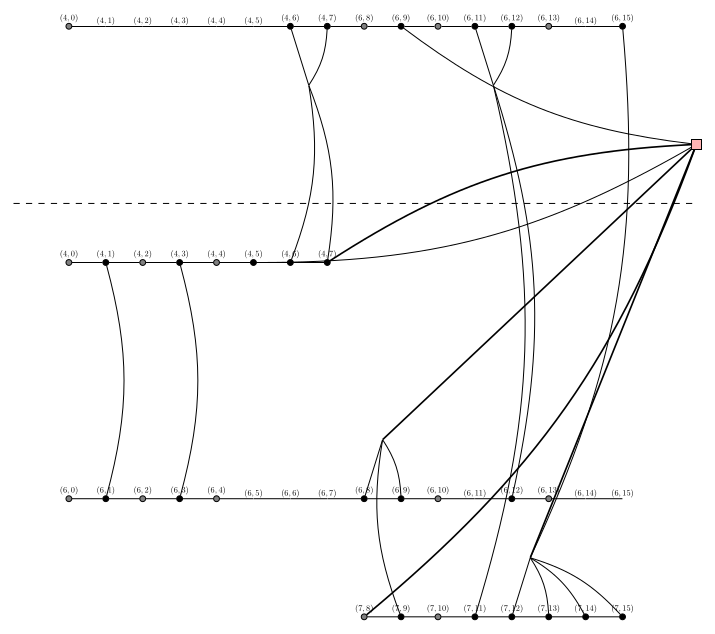

✓ Drawing completed successfully with fixes!


In [5]:
# Test the fixed drawing function with better positioning
if 'subgraphs' in locals() and len(subgraphs) > 0 and 'sub_partitions_list' in locals():
    print("Testing improved subgraph drawing...")
    
    # Test with the first subgraph
    test_subgraph = subgraphs[0] 
    test_assignment = sub_partitions_list[0]
    test_qpu_sizes = qpu_size_list[0]
    test_assignment_map = assignment_map_list[0]
    test_node_map = node_maps[0]
    
    print(f"Drawing subgraph with {len(test_subgraph.nodes)} nodes")
    print(f"QPU sizes: {test_qpu_sizes}")
    print(f"Assignment map size: {len(test_assignment_map)}")
    
    %load_ext jupyter_tikz
    try:
        fig = draw_subgraph_tikz(test_subgraph, test_assignment, test_qpu_sizes, test_assignment_map, test_node_map)
        display(fig)
        print("✓ Drawing completed successfully with fixes!")
    except Exception as e:
        print(f"✗ Drawing failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Required variables not available for testing")

In [6]:
# Debug the hyperedge structure to find dummy node self-connection issue
if 'subgraphs' in locals() and len(subgraphs) > 0:
    debug_subgraph = subgraphs[0]
    print("Debugging hyperedge structure...")
    
    dummy_edges = []
    problematic_edges = []
    
    for edge_id, edge_info in debug_subgraph.hyperedges.items():
        roots = edge_info.get('root_set', set())
        receivers = edge_info.get('receiver_set', set())
        
        # Check for dummy nodes in this edge
        dummy_in_roots = any(isinstance(r, tuple) and len(r) > 0 and r[0] == "dummy" for r in roots)
        dummy_in_receivers = any(isinstance(r, tuple) and len(r) > 0 and r[0] == "dummy" for r in receivers)
        
        if dummy_in_roots or dummy_in_receivers:
            dummy_edges.append((edge_id, edge_info))
            print(f"\nDummy edge found:")
            print(f"  Edge ID: {edge_id}")
            print(f"  Roots: {roots}")
            print(f"  Receivers: {receivers}")
            
            # Check for self-connections
            overlapping_nodes = roots.intersection(receivers)
            if overlapping_nodes:
                print(f"  ⚠️  SELF-CONNECTION: {overlapping_nodes}")
                problematic_edges.append((edge_id, edge_info, overlapping_nodes))
        
        # Check for malformed edge_id
        if isinstance(edge_id, tuple) and len(edge_id) < 2:
            print(f"⚠️  Malformed edge_id: {edge_id}")
            problematic_edges.append((edge_id, edge_info, "malformed_id"))
    
    print(f"\nSummary:")
    print(f"Total dummy edges: {len(dummy_edges)}")
    print(f"Problematic edges: {len(problematic_edges)}")
    
    if problematic_edges:
        print(f"\nProblematic edges details:")
        for i, (edge_id, edge_info, issue) in enumerate(problematic_edges):
            print(f"  {i+1}. Edge ID: {edge_id}, Issue: {issue}")
    
    # Also check the structure of dummy nodes themselves
    dummy_nodes = [n for n in debug_subgraph.nodes if isinstance(n, tuple) and len(n) > 0 and n[0] == "dummy"]
    print(f"\nDummy nodes in subgraph: {len(dummy_nodes)}")
    for i, dummy in enumerate(dummy_nodes[:3]):  # Show first 3
        print(f"  {i+1}. {dummy}")
        
        # Check if this dummy appears in node_name issues
        try:
            from disqco.drawing.tikz_drawing import node_name
            test_name = "n_" + "_".join(str(x) for x in dummy)
            print(f"     Node name: {test_name}")
        except Exception as e:
            print(f"     ⚠️  Node name error: {e}")

else:
    print("No subgraphs available for debugging")

Debugging hyperedge structure...

Dummy edge found:
  Edge ID: ((4, 7), (4, 8))
  Roots: {(4, 7)}
  Receivers: {('dummy', 1, 3, 0)}

Dummy edge found:
  Edge ID: ((7, 7), (7, 8))
  Roots: {('dummy', 1, 3, 0)}
  Receivers: {(7, 8)}

Dummy edge found:
  Edge ID: (2, 4)
  Roots: {('dummy', 1, 3, 0)}
  Receivers: {(4, 5)}

Dummy edge found:
  Edge ID: (0, 7)
  Roots: {('dummy', 1, 3, 0)}
  Receivers: {(1, 9)}

Dummy edge found:
  Edge ID: (6, 8)
  Roots: {(6, 8), (6, 9)}
  Receivers: {(7, 9), ('dummy', 1, 3, 0)}

Dummy edge found:
  Edge ID: (7, 12)
  Roots: {(7, 15), (7, 12), (7, 13), (7, 14)}
  Receivers: {(1, 15), ('dummy', 1, 3, 0)}

Summary:
Total dummy edges: 6
Problematic edges: 0

Dummy nodes in subgraph: 1
  1. ('dummy', 1, 3, 0)
     ⚠️  Node name error: cannot import name 'node_name' from 'disqco.drawing.tikz_drawing' (/Users/ftb123/MLQCP_FM/src/disqco/drawing/tikz_drawing.py)
